In [3]:
import pandas as pd
import numpy as np
import os
import sumolib
import random
from tqdm import tqdm
from datetime import datetime

# A. 이동류 매칭

In [4]:
# [이동류번호] 불러오기 (약 1분의 소요시간)
path_moves = '../../Data/tables/moves/'
csv_moves = os.listdir('../../Data/tables/moves/')
moves = [pd.read_csv(path_moves + csv_move, index_col=0) for csv_move in tqdm(csv_moves)]
match1 = pd.concat(moves).drop_duplicates().sort_values(by=['inter_no','phas_A','phas_B']).reset_index(drop=True)
match1.head(10)

100%|██████████| 17280/17280 [00:15<00:00, 1105.34it/s]


inter_no  phas_A  phas_B  move_A  move_B
0       175       1       1       8       4
1       175       2       2       7       3
2       175       3       3       6       1
3       175       3       4       6       2
4       175       4       4       5       2
5       176       1       1       8       4
6       176       2       2       8       3
7       176       3       3       5      18
8       177       1       1       8       4
9       177       2       2       7       3

In [5]:
# 계층화 (inter_no, phas_A, phas_B, move_A, move_B) -> ('inter_no', 'phase_no', 'ring_type', 'move_no')
matchA = match1[['inter_no', 'phas_A', 'move_A']].copy()
matchA.columns = ['inter_no', 'phase_no', 'move_no']
matchA['ring_type'] = 'A'
matchB = match1[['inter_no', 'phas_B', 'move_B']].copy()
matchB.columns = ['inter_no', 'phase_no', 'move_no']
matchB['ring_type'] = 'B'
match2 = pd.concat([matchA, matchB]).drop_duplicates()
match2 = match2[['inter_no', 'phase_no', 'ring_type', 'move_no']]
match2 = match2.sort_values(by=list(match2.columns))
match2.head(10)

inter_no  phase_no ring_type  move_no
0       175         1         A        8
0       175         1         B        4
1       175         2         A        7
1       175         2         B        3
2       175         3         A        6
2       175         3         B        1
4       175         4         A        5
3       175         4         B        2
5       176         1         A        8
5       176         1         B        4

In [6]:
# [nema 이동류목록] 불러오기 및 병합
nema = pd.read_csv('../../Data/tables/nema.csv', encoding='cp949')
match3 = pd.merge(match2, nema, how='left', on='move_no').drop_duplicates()
match3

inter_no  phase_no ring_type  move_no inc_dir out_dir
0        175         1         A        8       남       북
1        175         1         B        4       북       남
2        175         2         A        7       북       동
3        175         2         B        3       남       서
4        175         3         A        6       동       서
5        175         3         B        1       동       남
6        175         4         A        5       서       북
7        175         4         B        2       서       동
8        176         1         A        8       남       북
9        176         1         B        4       북       남
10       176         2         A        8       남       북
11       176         2         B        3       남       서
12       176         3         A        5       서       북
13       176         3         B       18     NaN     NaN
14       177         1         A        8       남       북
15       177         1         B        4       북       남
16       177         2         A        7       북       동
17       177         2         B        3       남       서
18       177         3         A       17     NaN     NaN
19       177         3         B       18     NaN     NaN
20       177         4         A        5       서       북
21       177         4         B        1       동       남
22       178         1         A        8       남       북
23       178         1         B        4       북       남
24       178         2         A        7       북       동
25       178         2         B        3       남       서
26       178         3         A        5       서       북
27       178         3         B        2       서       동
28       178         4         A        6       동       서
29       178         4         B        1       동       남
30       201         1         A        8       남       북
31       201         1         B        3       남       서
32       201         2         A        5       서       북
33       201         2         B        2       서       동
34       201         3         A        6       동       서
35       201         3         B        2       서       동
36       201         4         A        6       동       서
37       201         4         B        1       동       남
38       201         5         A        7       북       동
39       201         5         B        4       북       남
40       202         1         A        6       동       서
41       202         1         B        2       서       동
42       202         2         A       17     NaN     NaN
43       202         2         B       18     NaN     NaN
44       206         1         A        8       남       북
45       206         1         B        4       북       남
46       206         2         A       17     NaN     NaN
47       206         2         B       18     NaN     NaN
48       206         3         A        8       남       북
49       206         3         B        4       북       남
50       206         4         A       17     NaN     NaN
51       206         4         B       18     NaN     NaN
52       210         1         A        6       동       서
53       210         1         B       18     NaN     NaN
54       210         2         A        5       서       북
55       210         2         B        2       서       동
56       210         3         A        7       북       동
57       210         3         B        4       북       남
58       210         4         A        8       남       북
59       210         4         B        3       남       서

In [7]:
# [방위각정보] 불러오기, 계층화, 병합
# 불러오기
dtype_dict = {f'angle_{alph}{j}':'str' for alph in ['A', 'B'] for j in range(1,9)}
angle_original = pd.read_csv('../../Data/tables/angle.csv', index_col=0, dtype = dtype_dict)
# 계층화
angle = []
for i, row in angle_original.iterrows():
    angle_codes = row[[f'angle_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]]
    new = pd.DataFrame({'inter_no':[row.inter_no] * 16, 'phase_no':list(range(1, 9))*2, 'ring_type':['A'] * 8 + ['B'] * 8, 'angle_code':angle_codes.to_list()})
    angle.append(new)
angle = pd.concat(angle)
angle = angle.dropna().reset_index(drop=True)
# 병합
six_chars = angle.angle_code.apply(lambda x:len(x)==6)
angle.loc[six_chars,'inc_angle'] = angle.angle_code.apply(lambda x:x[:3])
angle.loc[six_chars,'out_angle'] = angle.angle_code.apply(lambda x:x[3:])
angle = angle.drop('angle_code', axis=1)
match4 = pd.merge(match3, angle, how='left', left_on=['inter_no', 'phase_no', 'ring_type'],
                 right_on=['inter_no', 'phase_no', 'ring_type']).drop_duplicates()
match4

inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle
0        175         1         A        8       남       북       179       004
1        175         1         B        4       북       남       003       176
2        175         2         A        7       북       동       001       095
3        175         2         B        3       남       서       179       270
4        175         3         A        6       동       서       090       270
5        175         3         B        1       동       남       090       180
6        175         4         A        5       서       북       268       000
7        175         4         B        2       서       동       270       090
8        176         1         A        8       남       북       180       000
9        176         1         B        4       북       남       359       180
10       176         2         A        8       남       북       180       000
11       176         2         B        3       남       서       180       270
12       176         3         A        5       서       북       270       356
13       176         3         B       18     NaN     NaN       NaN       NaN
14       177         1         A        8       남       북       180       000
15       177         1         B        4       북       남       001       176
16       177         2         A        7       북       동       000       090
17       177         2         B        3       남       서       179       270
18       177         3         A       17     NaN     NaN       NaN       NaN
19       177         3         B       18     NaN     NaN       NaN       NaN
20       177         4         A        5       서       북       268       000
21       177         4         B        1       동       남       090       180
22       178         1         A        8       남       북       180       000
23       178         1         B        4       북       남       000       180
24       178         2         A        7       북       동       000       090
25       178         2         B        3       남       서       180       270
26       178         3         A        5       서       북       270       000
27       178         3         B        2       서       동       270       090
28       178         4         A        6       동       서       090       270
29       178         4         B        1       동       남       090       180
30       201         1         A        8       남       북       180       000
31       201         1         B        3       남       서       180       270
32       201         2         A        5       서       북       270       000
33       201         2         B        2       서       동       270       090
34       201         3         A        6       동       서       090       270
35       201         3         B        2       서       동       270       090
36       201         4         A        6       동       서       090       270
37       201         4         B        1       동       남       090       180
38       201         5         A        7       북       동       000       090
39       201         5         B        4       북       남       000       180
40       202         1         A        6       동       서       090       270
41       202         1         B        2       서       동       270       090
42       202         2         A       17     NaN     NaN       NaN       NaN
43       202         2         B       18     NaN     NaN       NaN       NaN
44       206         1         A        8       남       북       180       000
45       206         1         B        4       북       남       000       180
46       206         2         A       17     NaN     NaN       NaN       NaN
47       206         2         B       18     NaN     NaN       NaN       NaN
48       206         3         A        8       남       북       180       000
49       206         3         B        4       북       남       000       180
50       206         4    

In [8]:
# [네트워크], [교차로-노드 매칭], [교차로정보] 불러오기
net = sumolib.net.readNet('../../Data/networks/SN_sample.net.xml')
inter_node = pd.read_csv('../../Data/tables/inter_node.csv', index_col=0)
inter_info = pd.read_csv('../../Data/tables/inter_info.csv', index_col=0)

inter_node1 = inter_node[inter_node.inter_type == 'parent'].drop('inter_type', axis=1)
inter_info1 = inter_info[['inter_no', 'inter_lat', 'inter_lon']]
inter = pd.merge(inter_node1, inter_info1, how='left', left_on=['inter_no'],
                 right_on=['inter_no']).drop_duplicates()

inter2node = dict(zip(inter['inter_no'], inter['node_id']))

match5 = match4.copy()
# 진입진출ID 매칭
for index, row in match5.iterrows():
    node_id = inter2node[row.inter_no]
    node = net.getNode(node_id)
    # 교차로의 모든 (from / to) edges
    inc_edges = [edge for edge in node.getIncoming() if edge.getFunction() == ''] # incoming edges
    out_edges = [edge for edge in node.getOutgoing() if edge.getFunction() == ''] # outgoing edges
    # 교차로의 모든 (from / to) directions
    inc_dirs = []
    for inc_edge in inc_edges:
        start = inc_edge.getShape()[-2]
        end = inc_edge.getShape()[-1]
        inc_dir = np.array(end) - np.array(start)
        inc_dir = inc_dir / (inc_dir ** 2).sum() ** 0.5
        inc_dirs.append(inc_dir)
    out_dirs = []
    for out_edge in out_edges:
        start = out_edge.getShape()[0]
        end = out_edge.getShape()[1]
        out_dir = np.array(end) - np.array(start)
        out_dir = out_dir / (out_dir ** 2).sum() ** 0.5
        out_dirs.append(out_dir)
    # 진입각, 진출각 불러오기
    if not pd.isna(row.inc_angle):
        inc_angle = int(row.inc_angle)
        out_angle = int(row.out_angle)
        # 방위각을 일반각으로 가공, 라디안 변환, 단위벡터로 변환
        inc_angle = (-90 - inc_angle) % 360
        inc_angle = inc_angle * np.pi / 180.
        inc_dir_true = np.array([np.cos(inc_angle), np.sin(inc_angle)])
        out_angle = (90 - out_angle) % 360
        out_angle = out_angle * np.pi / 180.
        out_dir_true = np.array([np.cos(out_angle), np.sin(out_angle)])
        # 매칭 엣지 반환
        inc_index = np.array([np.dot(inc_dir, inc_dir_true) for inc_dir in inc_dirs]).argmax()
        out_index = np.array([np.dot(out_dir, out_dir_true) for out_dir in out_dirs]).argmax()
        inc_edge_id = inc_edges[inc_index].getID()
        out_edge_id   = out_edges[out_index].getID()
        match5.at[index, 'inc_edge'] = inc_edge_id
        match5.at[index, 'out_edge'] = out_edge_id
match5['node_id'] = match5['inter_no'].map(inter2node)
match5 = match5.sort_values(by=['inter_no','phase_no','ring_type']).reset_index(drop=True)
match5

inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle  \
0        175         1         A        8       남       북       179       004   
1        175         1         B        4       북       남       003       176   
2        175         2         A        7       북       동       001       095   
3        175         2         B        3       남       서       179       270   
4        175         3         A        6       동       서       090       270   
5        175         3         B        1       동       남       090       180   
6        175         4         A        5       서       북       268       000   
7        175         4         B        2       서       동       270       090   
8        176         1         A        8       남       북       180       000   
9        176         1         B        4       북       남       359       180   
10       176         2         A        8       남       북       180       000   
11       176         2         B        3       남       서       180       270   
12       176         3         A        5       서       북       270       356   
13       176         3         B       18     NaN     NaN       NaN       NaN   
14       177         1         A        8       남       북       180       000   
15       177         1         B        4       북       남       001       176   
16       177         2         A        7       북       동       000       090   
17       177         2         B        3       남       서       179       270   
18       177         3         A       17     NaN     NaN       NaN       NaN   
19       177         3         B       18     NaN     NaN       NaN       NaN   
20       177         4         A        5       서       북       268       000   
21       177         4         B        1       동       남       090       180   
22       178         1         A        8       남       북       180       000   
23       178         1         B        4       북       남       000       180   
24       178         2         A        7       북       동       000       090   
25       178         2         B        3       남       서       180       270   
26       178         3         A        5       서       북       270       000   
27       178         3         B        2       서       동       270       090   
28       178         4         A        6       동       서       090       270   
29       178         4         B        1       동       남       090       180   
30       201         1         A        8       남       북       180       000   
31       201         1         B        3       남       서       180       270   
32       201         2         A        5       서       북       270       000   
33       201         2         B        2       서       동       270       090   
34       201         3         A        6       동       서       090       270   
35       201         3         B        2       서       동       270       090   
36       201         4         A        6       동       서       090       270   
37       201         4         B        1       동       남       090       180   
38       201         5         A        7       북       동       000       090   
39       201         5         B        4       북       남       000       180   
40       202         1         A        6       동       서       090       270   
41       202         1         B        2       서       동       270       090   
42       202         2         A       17     NaN     NaN       NaN       NaN   
43       202         2         B       18     NaN     NaN       NaN       NaN   
44       206         1         A        8       남       북       180       000   
45       206         1         B        4       북       남       000       180   
46       206         2         A       17     NaN     NaN       NaN       NaN   
47       206         2         B       18     NaN     NaN       NaN       NaN   
48       206         3         A   

In [9]:
# 유턴/연동교차로에 대하여 진입ID, 진출ID 부여
node2inter = dict(zip(inter_node['node_id'], inter_node['inter_no']))

uturn = pd.read_csv('../../Data/tables/child_uturn.csv')
coord = pd.read_csv('../../Data/tables/child_coord.csv')

child_ids = inter_node[inter_node.inter_type=='child'].node_id.unique()
ch2pa = {} # child to parent
for child_id in child_ids:
    parent_no = inter_node[inter_node.node_id==child_id].inter_no.iloc[0]
    sub_inter_node = inter_node[inter_node.inter_no==parent_no]
    ch2pa[child_id] = sub_inter_node[sub_inter_node.inter_type=='parent'].iloc[0].node_id
directions = ['북', '북동', '동', '남동', '남', '남서', '서', '북서'] # 정북기준 시계방향으로 8방향
u_ids = uturn.child_id.unique()
u_ids

array(['u00', 'u20', 'u30', 'u31', 'u32', 'u60'], dtype=object)

In [10]:
# 유턴/연동교차로에 대하여 진입ID, 진출ID 부여
node2inter = dict(zip(inter_node['node_id'], inter_node['inter_no']))

uturn = pd.read_csv('../../Data/tables/child_uturn.csv')
coord = pd.read_csv('../../Data/tables/child_coord.csv')
child_ids = inter_node[inter_node.inter_type=='child'].node_id.unique()
ch2pa = {} # child to parent
for child_id in child_ids:
    parent_no = inter_node[inter_node.node_id==child_id].inter_no.iloc[0]
    sub_inter_node = inter_node[inter_node.inter_no==parent_no]
    ch2pa[child_id] = sub_inter_node[sub_inter_node.inter_type=='parent'].iloc[0].node_id
directions = ['북', '북동', '동', '남동', '남', '남서', '서', '북서'] # 정북기준 시계방향으로 8방향
u_ids = uturn.child_id.unique()
# 각 child uturn node에 대하여 (inc_edge_id, out_edge_id) 부여
cmatches = []
for _, row in uturn.iterrows():
    child_id = row.child_id
    parent_id = row.parent_id
    direction = row.direction
    condition = row.condition
    inc_edge_id = row.inc_edge
    out_edge_id = row.out_edge
    ind = directions.index(direction)
    if condition == "좌회전시":
        print(child_id, parent_id, condition, direction)
        inc_dire = direction
        out_dire_A = out_dire_B = directions[(ind + 2) % len(directions)]
    elif condition == "직진시":
        print(child_id, parent_id, condition, direction)
        inc_dire = direction
        out_dire_A = out_dire_B = directions[(ind + 4) % len(directions)]
    elif condition == "직좌시":
        print(child_id, parent_id, condition, direction)
        inc_dire = direction
        out_dire_A = directions[(ind + 2) % len(directions)]
        out_dire_B = directions[(ind + 4) % len(directions)]
    elif condition == "보행신호시":
        print(child_id, parent_id, condition, direction)
        inc_dire = directions[(ind + 2) % len(directions)]
        out_dire_A = directions[(ind - 2) % len(directions)]
        out_dire_B = directions[(ind - 2) % len(directions)]
    cmatch = match5.copy()[match5.node_id==parent_id] # match dataframe for a child node
    cmatch = cmatch.sort_values(by=['phase_no', 'ring_type']).reset_index(drop=True)
    cmatch['node_id'] = child_id
    cmatch[['inc_edge', 'out_edge']] = np.nan
    if condition == '직좌시':
        ap = cmatch[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_A)].phase_no.iloc[0]
        bp = cmatch[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_B)].phase_no.iloc[0]
        # 직진과 좌회전이 같은 현시에 있는 경우에만 (inc_edge_id, out_edge_id)를 부여한다.
        if ap == bp:
            cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_A), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
            cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_B), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
    elif condition == '보행신호시':
        cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_A), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
        cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_B), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
        # 이동류번호가 17(보행신호)이면서 유턴노드방향으로 가는 신호가 없으면 (inc_edge_id, out_edge_id)를 부여한다.
        cmatch.loc[(cmatch.move_no==17) & (cmatch.out_dir!=direction), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
    else:
        cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_A), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
        cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_B), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
    # 유턴신호의 이동류번호를 19로 부여한다.
    cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_A), 'move_no'] = 19
    cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_B), 'move_no'] = 19
    display(cmatch)
    cmatches.append(cmatch)

# 각 child coordination node에 대하여 (inc_edge_id, out_edge_id) 부여
coord['inter_no'] = coord['parent_id'].map(node2inter)
coord = coord.rename(columns={'child_id':'node_id'})
coord[['inc_dir', 'out_dir', 'inc_angle','out_angle']] = np.nan
coord['move_no'] = 20
coord = coord[['inter_no', 'phase_no', 'ring_type', 'move_no', 'inc_dir', 'out_dir', 'inc_angle','out_angle', 'inc_edge', 'out_edge', 'node_id']]
# display(coord)
cmatches = pd.concat(cmatches)
display(coord)
match6 = pd.concat([match5, cmatches, coord]).drop_duplicates().sort_values(by=['inter_no', 'node_id', 'phase_no', 'ring_type'])
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
match6.to_csv('../../Data/tables/matching/match6.csv')
display(match6)

u00 i0 좌회전시 북


inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle  \
0       175         1         A        8       남       북       179       004   
1       175         1         B        4       북       남       003       176   
2       175         2         A       19       북       동       001       095   
3       175         2         B        3       남       서       179       270   
4       175         3         A        6       동       서       090       270   
5       175         3         B        1       동       남       090       180   
6       175         4         A        5       서       북       268       000   
7       175         4         B        2       서       동       270       090   

       inc_edge         out_edge node_id  
0           NaN              NaN     u00  
1           NaN              NaN     u00  
2  571500487_02  571500487_01.32     u00  
3           NaN              NaN     u00  
4           NaN              NaN     u00  
5           NaN              NaN     u00  
6           NaN              NaN     u00  
7           NaN              NaN     u00

u20 i2 보행신호시 북


inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle  \
0       177         1         A        8       남       북       180       000   
1       177         1         B        4       북       남       001       176   
2       177         2         A        7       북       동       000       090   
3       177         2         B        3       남       서       179       270   
4       177         3         A       17     NaN     NaN       NaN       NaN   
5       177         3         B       18     NaN     NaN       NaN       NaN   
6       177         4         A        5       서       북       268       000   
7       177         4         B        1       동       남       090       180   

          inc_edge      out_edge node_id  
0              NaN           NaN     u20  
1              NaN           NaN     u20  
2              NaN           NaN     u20  
3              NaN           NaN     u20  
4  571542810_01.51  571542810_02     u20  
5              NaN           NaN     u20  
6              NaN           NaN     u20  
7              NaN           NaN     u20

u30 i3 보행신호시 북


inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle  \
0       178         1         A        8       남       북       180       000   
1       178         1         B        4       북       남       000       180   
2       178         2         A        7       북       동       000       090   
3       178         2         B        3       남       서       180       270   
4       178         3         A        5       서       북       270       000   
5       178         3         B        2       서       동       270       090   
6       178         4         A       19       동       서       090       270   
7       178         4         B        1       동       남       090       180   

       inc_edge      out_edge node_id  
0           NaN           NaN     u30  
1           NaN           NaN     u30  
2           NaN           NaN     u30  
3           NaN           NaN     u30  
4           NaN           NaN     u30  
5           NaN           NaN     u30  
6  571556452_01  571556452_02     u30  
7           NaN           NaN     u30

u31 i3 보행신호시 동


inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle  \
0       178         1         A       19       남       북       180       000   
1       178         1         B        4       북       남       000       180   
2       178         2         A        7       북       동       000       090   
3       178         2         B        3       남       서       180       270   
4       178         3         A        5       서       북       270       000   
5       178         3         B        2       서       동       270       090   
6       178         4         A        6       동       서       090       270   
7       178         4         B        1       동       남       090       180   

       inc_edge         out_edge node_id  
0  571500475_02  571500475_01.26     u31  
1           NaN              NaN     u31  
2           NaN              NaN     u31  
3           NaN              NaN     u31  
4           NaN              NaN     u31  
5           NaN              NaN     u31  
6           NaN              NaN     u31  
7           NaN              NaN     u31

u32 i3 보행신호시 서


inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle  \
0       178         1         A        8       남       북       180       000   
1       178         1         B       19       북       남       000       180   
2       178         2         A        7       북       동       000       090   
3       178         2         B        3       남       서       180       270   
4       178         3         A        5       서       북       270       000   
5       178         3         B        2       서       동       270       090   
6       178         4         A        6       동       서       090       270   
7       178         4         B        1       동       남       090       180   

       inc_edge       out_edge node_id  
0           NaN            NaN     u32  
1  571540303_02  -571540303_02     u32  
2           NaN            NaN     u32  
3           NaN            NaN     u32  
4           NaN            NaN     u32  
5           NaN            NaN     u32  
6           NaN            NaN     u32  
7           NaN            NaN     u32

u60 i6 직좌시 서


inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle  \
0       210         1         A        6       동       서       090       270   
1       210         1         B       18     NaN     NaN       NaN       NaN   
2       210         2         A       19       서       북       268       000   
3       210         2         B       19       서       동       270       090   
4       210         3         A        7       북       동       359       090   
5       210         3         B        4       북       남       000       180   
6       210         4         A        8       남       북       180       000   
7       210         4         B        3       남       서       180       270   

       inc_edge       out_edge node_id  
0           NaN            NaN     u60  
1           NaN            NaN     u60  
2  571500535_02  -571500535_02     u60  
3  571500535_02  -571500535_02     u60  
4           NaN            NaN     u60  
5           NaN            NaN     u60  
6           NaN            NaN     u60  
7           NaN            NaN     u60

inter_no  phase_no ring_type  move_no  inc_dir  out_dir  inc_angle  \
0       178         1         A       20      NaN      NaN        NaN   
1       178         1         B       20      NaN      NaN        NaN   
2       178         2         A       20      NaN      NaN        NaN   
3       178         2         B       20      NaN      NaN        NaN   
4       178         3         A       20      NaN      NaN        NaN   
5       178         3         B       20      NaN      NaN        NaN   
6       178         4         A       20      NaN      NaN        NaN   
7       178         4         B       20      NaN      NaN        NaN   

   out_angle         inc_edge          out_edge node_id  
0        NaN              NaN               NaN     c30  
1        NaN              NaN               NaN     c30  
2        NaN     571542116_01  -571542116_02.96     c30  
3        NaN  571542116_02.96  571542116_02.164     c30  
4        NaN     571542116_01  -571542116_02.96     c30  
5        NaN  571542116_02.96  571542116_02.164     c30  
6        NaN     571542116_01  -571542116_02.96     c30  
7        NaN  571542116_02.96  571542116_02.164     c30

inter_no  phase_no ring_type  move_no inc_dir out_dir inc_angle out_angle  \
0        175         1         A        8       남       북       179       004   
1        175         1         B        4       북       남       003       176   
2        175         2         A        7       북       동       001       095   
3        175         2         B        3       남       서       179       270   
4        175         3         A        6       동       서       090       270   
..       ...       ...       ...      ...     ...     ...       ...       ...   
3        210         2         B       19       서       동       270       090   
4        210         3         A        7       북       동       359       090   
5        210         3         B        4       북       남       000       180   
6        210         4         A        8       남       북       180       000   
7        210         4         B        3       남       서       180       270   

         inc_edge       out_edge node_id  
0   -571542797_02   571500487_01      i0  
1   -571500487_01   571542797_02      i0  
2   -571500487_01   571545870_01      i0  
3   -571542797_02   571510153_01      i0  
4    571545870_02   571510153_01      i0  
..            ...            ...     ...  
3    571500535_02  -571500535_02     u60  
4             NaN            NaN     u60  
5             NaN            NaN     u60  
6             NaN            NaN     u60  
7             NaN            NaN     u60  

[116 rows x 11 columns]

In [11]:
# 이동류 매칭
# 각 교차로에 대하여, 가능한 모든 이동류(1~18, 21)에 대한 진입·진출엣지ID를 지정한다.
# 모든 이동류에 대해 지정하므로, 시차제시 이전과 다른 이동류가 등장하더라도 항상 진입·진출 엣지 ID를 지정할 수 있다.
match7 = match6.copy()
match7 = match7[['inter_no', 'move_no', 'inc_dir', 'out_dir', 'inc_edge', 'out_edge', 'node_id']]

parent_ids = sorted(inter_node[inter_node.inter_type=='parent'].node_id.unique())
child_ids = sorted(inter_node[inter_node.inter_type=='child'].node_id.unique())

# (1) 가능한 (진입방향, 진출방향) 목록
flows = nema.dropna().apply(lambda row: (row['inc_dir'], row['out_dir']), axis=1).tolist()
# (2) 각 교차로별 방향 목록 : pdires (possible directions)
pdires = {}
for node_id in parent_ids:
    dires = match7[match7.node_id == node_id][['inc_dir','out_dir']].values.flatten()
    dires = {dire for dire in dires if type(dire)==str}
    pdires[node_id] = dires
# (3) 각 (교차로, 진입방향) 별 진입id 목록 : inc2id (incoming direction to incoming edge_id)
inc2id = {}
for node_id in parent_ids:
    for inc_dir in pdires[node_id]:
        df = match7[(match7.node_id==node_id) & (match7.inc_dir==inc_dir)]
        inc2id[(node_id, inc_dir)] = df.inc_edge.iloc[0]
# (4) 각 (교차로, 진출방향) 별 진출id 목록 : out2id (outgoing direction to outgoing edge_id)
out2id = {}
for node_id in parent_ids:
    for out_dir in pdires[node_id]:
        df = match7[(match7.node_id==node_id) & (match7.out_dir==out_dir)]
        out2id[(node_id, out_dir)] = df.out_edge.iloc[0]
# (5) 각 교차로별 가능한 (진입방향, 진출방향) 목록 : pflow (possible flows)
pflow = {}
for node_id in parent_ids:
    pflow[node_id] = [flow for flow in flows if set(flow).issubset(pdires[node_id])]
# (6) 가능한 이동류에 대하여 진입id, 진출id 배정 : matching
node2inter = dict(zip(match7['node_id'], match7['inter_no']))
dires_right = ['북', '서', '남', '동', '북'] # ex (북, 서), (서, 남) 등은 우회전 flow
matching = []
for node_id in parent_ids:
    inter_no = node2inter[node_id]
    # 좌회전과 직진(1 ~ 16)
    for (inc_dir, out_dir) in pflow[node_id]:
        move_no = nema[(nema.inc_dir==inc_dir) & (nema.out_dir==out_dir)].move_no.iloc[0]
        inc_edge = inc2id[(node_id, inc_dir)]
        out_edge = out2id[(node_id, out_dir)]
        new_row = pd.DataFrame({'inter_no':[inter_no], 'move_no':[move_no],
                                'inc_dir':[inc_dir], 'out_dir':[out_dir],
                                'inc_edge':[inc_edge], 'out_edge':[out_edge], 'node_id':[node_id]})
        matching.append(new_row)
    # 보행신호(17), 전적색(18)
    new_row = pd.DataFrame({'inter_no':[inter_no] * 2, 'move_no':[17, 18],
                            'inc_dir':[None]*2, 'out_dir':[None]*2,
                            'inc_edge':[None]*2, 'out_edge':[None]*2, 'node_id':[node_id]*2})
    matching.append(new_row)
    # 신호우회전(21)
    for d in range(len(dires_right)-1):
        inc_dir = dires_right[d]
        out_dir = dires_right[d+1]
        if {inc_dir, out_dir}.issubset(pdires[node_id]):
            inc_edge = inc2id[(node_id, inc_dir)]
            out_edge = out2id[(node_id, out_dir)]
            new_row = pd.DataFrame({'inter_no':[inter_no], 'move_no':[21],
                                    'inc_dir':[inc_dir], 'out_dir':[out_dir],
                                    'inc_edge':[inc_edge], 'out_edge':[out_edge], 'node_id':[node_id]})
            matching.append(new_row)
matching.append(match7[match7.node_id.isin(child_ids)])
matching = pd.concat(matching)
matching = matching.dropna().sort_values(by=['inter_no', 'node_id', 'move_no']).reset_index(drop=True)
matching['move_no'] = matching['move_no'].astype(int)
matching.to_csv('../../Data/tables/matching/matching.csv')
display(matching)

inter_no  move_no inc_dir out_dir          inc_edge      out_edge node_id
0        175        1       동       남      571545870_02  571542797_02      i0
1        175        2       서       동      571510153_02  571545870_01      i0
2        175        3       남       서     -571542797_02  571510153_01      i0
3        175        4       북       남     -571500487_01  571542797_02      i0
4        175        5       서       북      571510153_02  571500487_01      i0
..       ...      ...     ...     ...               ...           ...     ...
69       210        8       남       북      571500585_02  571511538_01      i6
70       210       21       북       서  571511538_02.121  571500535_01      i6
71       210       21       서       남   571500535_02.18  571500585_01      i6
72       210       21       남       동      571500585_02  571542115_01      i6
73       210       21       동       북     -571542115_01  571511538_01      i6

[74 rows x 7 columns]

# B. 5초 간격으로 이동류번호 수집

In [12]:
# 5초 단위로 이동류번호 저장 및 신호이력에서 유닉스시각 가져와서 표시, 한시간동안의 데이터만 보관
midnight = int(datetime(2024, 1, 5, 0, 0, 0).timestamp())
next_day = int(datetime(2024, 1, 6, 0, 0, 0).timestamp())
fsecs = range(midnight, next_day, 5) # fsecs : unix time by Five SECondS
fmins = range(midnight, next_day, 300) # fmins : unix time by Five MINuteS
# time2move = dict(zip(fsecs,moves)) # move : 어느 순간의 이동류정보
history = pd.read_csv('../../Data/tables/history.csv', index_col=0)

time2movement = {} # movement : 어느 순간의, 그 순간으로부터 한시간 동안의 (교차로번호 + 현시별이동류번호 + 시작시간)
# - 아래 절차를 5초마다 반복
for fsec in tqdm(fsecs): # fsec : unix time by Five SECond
    # 1. 상태 테이블 조회해서 전체 데이터중 필요데이터(교차로번호, A링 현시번호, A링 이동류번호, B링 현시번호, B링 이동류번호)만 수집 : A
    # move = time2move[fsec]
    move = pd.read_csv(f'../../Data/tables/moves/move_{fsec}.csv', index_col=0)
    # 2. 이력 테이블 조회해서 교차로별로 유닉스시간 최대인 데이터(교차로변호, 종료유닉스타임)만 수집 : B
    recent_histories = [group.iloc[-1:] for _, group in history[history['end_unix'] < fsec].groupby('inter_no')] # 교차로별로 유닉스시간이 최대인 행들
    if not recent_histories:
        rhistory = pd.DataFrame({'inter_no':[], 'end_unix':[]}) # recent history
    else:
        rhistory = pd.concat(recent_histories)
    recent_unix = rhistory[['inter_no', 'end_unix']]
    # 3. 상태 테이블 조회정보(A)와 이력 테이블 조회정보(B) 조인(키값 : 교차로번호) : C
    move = pd.merge(move, recent_unix, how='left', on='inter_no')
    move['end_unix'] = move['end_unix'].fillna(0).astype(int)
    move = move.drop_duplicates()
    # 4. C데이터 프레임에 신규 컬럼(시작 유닉스타임) 생성 후 종료유닉스 타임 값 입력, 종료 유닉스 타임 컬럼 제거
    move = move.rename(columns = {'end_unix':'start_unix'})
    # 5. 이동류 이력정보 READ
    #     - CSV 파일로 서버에 저장된 이동류정보를 읽어옴(파일이 없는 경우에는 데이터가 없는 프레임 D 생성)
    try:
        if isinstance(movement, pd.DataFrame): # movement가 존재할 경우 그걸 그대로 씀.
            pass
        else: 
            movement = pd.DataFrame()
    except NameError: # movement가 존재하지 않는 경우 생성
        movement = pd.DataFrame()
    # 6. 이동류 이력정보 데이터테이블(D)에 C데이터 add
    movement = pd.concat([movement, move])
    # 7. D데이터 프레임에서 중복데이터 제거(교차로번호, 시작 유닉스타임, A링 현시번호, B링 현시번호 같은 행은 제거)
    movement = movement.drop_duplicates(['inter_no','phas_A','phas_B','start_unix'])
    # 8. D데이터 보관 시간 기준시간을 시작 유닉스 타임의 최대값 - 3600을 값으로 산출하고, 보관 시간 기준시간보다 작은 시작 유닉스 타임을 가진 행은 모두 제거(1시간 데이터만 보관)
    movement = movement[movement.start_unix > fsec - 3600]
    movement = movement.sort_values(by=['start_unix','inter_no','phas_A','phas_B']).reset_index(drop=True)

    time2movement[fsec] = movement
    movement.to_csv(f'../../Data/tables/movements/movements_{fsec}.csv')

# 각 movement들의 길이 시각화
import matplotlib.pyplot as plt
plt.plot(fsecs, [len(time2movement[fsec]) for fsec in fsecs])
plt.close()

  0%|          | 0/17280 [00:00<?, ?it/s]

100%|██████████| 17280/17280 [02:18<00:00, 124.47it/s]


# C. 5분 간격으로 신호이력 수집 및 통합테이블 생성

In [13]:
plan = pd.read_csv('../../Data/tables/plan.csv', index_col=0)
history = pd.read_csv('../../Data/tables/history.csv', index_col=0)

In [14]:
# split, isplit : A,B 분리 혹은 통합시 사용될 수 있는 딕셔너리
splits = {} # splits maps (inter_no, start_hour, start_minute) to split
for i, row in plan.iterrows():
    inter_no = row.inter_no
    start_hour = row.start_hour
    start_minute = row.start_minute
    cycle = row.cycle
    cums_A = row[[f'dura_A{j}' for j in range(1,9)]].cumsum()
    cums_B = row[[f'dura_B{j}' for j in range(1,9)]].cumsum()
    splits[(inter_no, start_hour, start_minute)] = {} # split maps (phas_A, phas_B) to k
    k = 0
    for t in range(cycle):
        new_phas_A = len(cums_A[cums_A < t]) + 1
        new_phas_B = len(cums_B[cums_B < t]) + 1
        if k == 0 or ((new_phas_A, new_phas_B) != (phas_A, phas_B)):
            k += 1
        phas_A = new_phas_A
        phas_B = new_phas_B
        splits[(inter_no, start_hour, start_minute)][(phas_A, phas_B)] = k

isplits = {} # the inverse of splits
for i in splits:
    isplits[i] = {splits[i][k]:k for k in splits[i]} # isplit maps k to (phas_A, phas_B)

# timetable
timetable = plan[['start_hour', 'start_minute']].drop_duplicates()
timetable['start_seconds'] = midnight + timetable['start_hour'] * 3600 + timetable['start_minute'] * 60
timetable

start_hour  start_minute  start_seconds
0           0             0     1704380400
1           7             0     1704405600
2           9             0     1704412800
3          18            30     1704447000

In [15]:
def make_rhistory(m:int):
    '''
    input : m
     - m ranges from 0 to 287, but 0 makes an error where 288 = 86400//300
     - present_time = fmins[m] : 현재시점
     + fmins[m-2] : 시뮬레이션 시작시점
     + fmins[m-1] : 시뮬레이션 종료시점
    output : rhistory
     - recent history
     - 현재시각(present_time) 이전 1시간 동안의 신호이력에 대하여 결측치 및 이상치를 처리한 결과
     - 교차로번호(inter_no), 종료유닉스(end_unix), 현시시간(dur_Aj, dur_Bj), 주기(cycle), 옵셋(offset)
    '''
    fmins = range(midnight, next_day, 300) # fmins : unix time by Five MINuteS
    present_time = fmins[m] # 현재시점
    print(datetime.fromtimestamp(present_time))

    Rhists = [] # Recent history (1시간 이내)
    for inter_no in history.inter_no.unique():
        # - 5분마다 신호이력 데이터 수집해서 통합테이블 생성할때
        # 1. 조회시점의 유닉스 타임을 기준으로 신호이력의 유닉스 타임이 1시간 이내인(Rhist) 데이터 수집
        rhistory = history.copy() # recent history
        rhistory = rhistory[(rhistory.end_unix < present_time)]
        hours = np.array(range(midnight, next_day + 1, 3600))
        rhist = rhistory.copy()[rhistory.inter_no == inter_no] # 특정한 inter_no
        rhist = rhist.reset_index(drop=True)
        new_rows = []
        # 1-1. 결측치 처리 : 인접한 두 end_unix의 차이가 계획된 주기의 두 배보다 크면 결측이 일어났다고 판단
        for n in range(len(rhist) - 1):
            curr_unix = rhist.iloc[n].end_unix # current end_unix
            next_unix = rhist.iloc[n+1].end_unix # next end_unix
            cycle = rhist.iloc[n].cycle
            if next_unix - curr_unix >= 2 * cycle:
                # 현재 unix를 계획된 주기만큼 늘려가면서 한 행씩 채워나간다.
                #(다음 unix와의 차이가 계획된 주기보다 작거나 같아질 때까지)
                while next_unix - curr_unix > cycle:
                    curr_unix += cycle
                    start_seconds = np.array(timetable.start_seconds)
                    idx = (start_seconds <= curr_unix).sum() - 1
                    start_hour = timetable.iloc[idx].start_hour
                    start_minute = timetable.iloc[idx].start_minute
                    prow = plan[(plan.inter_no==inter_no) & (plan.start_hour==start_hour) & (plan.start_minute==start_minute)] # planned row
                    prow = prow.drop(['start_hour', 'start_minute'], axis=1)
                    prow['end_unix'] = curr_unix
                    cycle = prow.iloc[0].cycle
                    new_rows.append(prow)
        rhist = pd.concat([rhist] + new_rows).sort_values(['end_unix'])
        rhist = rhist.reset_index(drop=True)

        # 1-2. 이상치 처리 : 기준유닉스로부터의 시간차이와 현시시간합이 11 이상 차이나면 이상치가 발생했다고 판단
        Rhist = rhist.copy() # recent history 1704393231
        Rhist = Rhist[(Rhist.end_unix >= present_time - 3600)] # Recent history (1시간 이내)
        Rhist = Rhist.reset_index(drop=True)
        Rhist['D_n'] = 0
        Rhist['S_n'] = 0
        for n in range(len(Rhist)):
            curr_unix = Rhist.iloc[n].end_unix # current end_unix
            cycle = Rhist.iloc[n].cycle
            ghour_lt_curr_unix = hours[hours < curr_unix].max() # the greatest hour less than curr_unix
            end_unixes = rhist.end_unix.unique()
            end_unixes_lt_ghour = np.sort(end_unixes[end_unixes < ghour_lt_curr_unix]) # end unixes less than ghour_lt_end_unix
            base_unix = end_unixes_lt_ghour[-5] # 기준유닉스 : curr_unix보다 작은 hour 중에서 가장 큰 값으로부터 다섯 번째로 작은 end_unix
            # D_n : 시간차이
            D_n = curr_unix - base_unix
            ddurations = rhist[(rhist.end_unix > base_unix) & (rhist.end_unix <= curr_unix)][[f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]]
            # S_n : 현시시간합
            S_n = ddurations.values.sum() // 2
            Rhist.loc[n, ['D_n', 'S_n']] = [D_n, S_n]
        n = 1
        while n < len(Rhist):
            prev_unix = Rhist[Rhist.index==n-1]['end_unix'].iloc[0] # previous end_unix
            curr_unix = Rhist[Rhist.index==n]['end_unix'].iloc[0] # current end_unix
            R_n = (curr_unix - prev_unix) / cycle
            ghour_lt_curr_unix = hours[hours < curr_unix].max() # the greatest hour less than curr_unix
            end_unixes = rhist.end_unix.unique()
            end_unixes_lt_ghour = np.sort(end_unixes[end_unixes < ghour_lt_curr_unix]) # end unixes less than ghour_lt_end_unix
            base_unix = end_unixes_lt_ghour[-5] # 기준유닉스 : curr_unix보다 작은 hour 중에서 가장 큰 값으로부터 다섯 번째로 작은 end_unix
            # D_n : 시간차이
            D_n = curr_unix - base_unix
            # S_n : 현시시간합
            ddurations = rhist[(rhist.end_unix > base_unix) & (rhist.end_unix <= curr_unix)][[f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]]
            S_n = ddurations.values.sum() // 2
            # 비율이 0.5보다 작거나 같으면 해당 행을 삭제
            if (abs(D_n - S_n) > 10) & (R_n <= 0.5):
                # print("lt", inter_no, curr_unix, round(R_n,2), D_n, S_n)
                # display(Rhist.iloc[n])
                Rhist = Rhist.drop(index=n)
                n += 1
                # 행삭제에 따른 curr_unix, D_n, S_n 등 재정의
                if not Rhist[Rhist.index==n]['end_unix'].empty: # 마지막 행을 삭제하여 뒤의 행이 없을 때를 대비
                    curr_unix = Rhist[Rhist.index==n]['end_unix'].iloc[0] # current end_unix
                    R_n = (curr_unix - prev_unix) / cycle
                    ghour_lt_curr_unix = hours[hours < curr_unix].max() # the greatest hour less than curr_unix
                    end_unixes = rhist.end_unix.unique()
                    end_unixes_lt_ghour = np.sort(end_unixes[end_unixes < ghour_lt_curr_unix]) # end unixes less than ghour_lt_end_unix
                    base_unix = end_unixes_lt_ghour[-5] # 기준유닉스 : curr_unix보다 작은 hour 중에서 가장 큰 값으로부터 다섯 번째로 작은 end_unix
                # D_n : 시간차이
                D_n = curr_unix - base_unix
                # S_n : 현시시간합
                ddurations = rhist[(rhist.end_unix > base_unix) & (rhist.end_unix <= curr_unix)][[f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]]
                S_n = ddurations.values.sum() // 2
            # 비율이 0.5보다 크면 해당 행 조정 (비율을 유지한 채로 현시시간 대체)
            if (abs(D_n - S_n) > 10) & (R_n > 0.5):
                start_seconds = np.array(timetable.start_seconds)
                idx = (start_seconds <= curr_unix).sum() - 1
                start_hour = timetable.iloc[idx].start_hour
                start_minute = timetable.iloc[idx].start_minute
                prow = plan[(plan.inter_no==inter_no) & (plan.start_hour==start_hour) & (plan.start_minute==start_minute)].copy().reset_index(drop=True).iloc[0] # planned row
                adjusted_dur = prow[[f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]] * R_n
                # 조정된 현시시간을 정수로 바꿈
                int_parts = adjusted_dur.apply(lambda x: int(x))
                frac_parts = adjusted_dur - int_parts
                difference = int(round(adjusted_dur.sum())) - int_parts.sum()
                # 소수 부분이 가장 큰 상위 'difference'개의 값에 대해 올림 처리
                for _ in range(difference):
                    max_frac_index = frac_parts.idxmax()
                    int_parts[max_frac_index] += 1
                    frac_parts[max_frac_index] = 0  # 이미 처리된 항목은 0으로 설정
                Rhist.loc[n, [f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]] = int_parts.values
                Rhist.loc[n, 'cycle'] = int_parts.sum() // 2
                # print("gt", inter_no, curr_unix, round(R_n,2), D_n, S_n)
            n += 1
        Rhist = Rhist.drop(columns=['offset', 'D_n', 'S_n'])
        Rhists.append(Rhist)
    Rhists = pd.concat(Rhists)
    Rhists = Rhists.sort_values(by=['end_unix', 'inter_no']).reset_index(drop=True)
    return Rhists

In [184]:
m = 100
fmins = range(midnight, next_day, 300) # fmins : unix time by Five MINuteS
present_time = fmins[m] # 현재시점
print(datetime.fromtimestamp(present_time))

# - 5분마다 신호이력 데이터 수집해서 통합테이블 생성할때
# 1. 조회시점의 유닉스 타임을 기준으로 신호이력의 유닉스 타임이 1시간 이내인(Rhist) 데이터 수집 <- 나중을 위해, 그냥 현재시점 이전의 데이터를 수집.
rhistory = history.copy() # recent history
rhistory = rhistory[(rhistory.end_unix < present_time)]

# 2. 시작 유닉스 타임컬럼 생성 후 종류 유닉스 타임에서 현시별 현시기간 컬럼의 합을 뺀 값으로 입력
# - 현시시간의 합을 뺀 시간의 +- 10초 이내에 이전 주기정보가 존재하면 그 유닉스 시간을 시작 유닉스시간 값으로 하고, 존재하지 않으면 현시시간의 합을 뺀 유닉스 시간을 시작 유닉스 시간으로 지정
for i, row in rhistory.iterrows():
    # 이전 유닉스 존재하지 않음 => 현시시간 합의 차
    # 이전 유닉스 존재, abs < 10 => 이전 유닉스
    # 이전 유닉스 존재, abs >=10 => 현시시간 합의 차
    inter_no = row.inter_no
    end_unix = row.end_unix
    elapsed_time = row[[f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]].sum() // 2 # 현시시간 합
    start_unix = end_unix - elapsed_time
    pre_rows = history[:i] # previous rows
    if inter_no in pre_rows.inter_no.unique(): # 이전 유닉스 존재
        pre_unix = pre_rows[pre_rows.inter_no == inter_no]['end_unix'].iloc[-1] # previous unix time
        if abs(pre_unix - start_unix) < 10: # abs < 10
            start_unix = pre_unix
        else: # abs >= 10
            pass
    rhistory.loc[i, 'start_unix'] = start_unix
rhistory[rhistory.isna()] = 0
rhistory['start_unix'] = rhistory['start_unix'].astype(int)
rhistory = rhistory[['inter_no', 'start_unix'] + [f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)] + ['cycle']]

# 계층화된 형태로 변환
hrhistory = [] # hierarchied recent history
for i, row in rhistory.iterrows():
    inter_no = row.inter_no
    start_unix = row.start_unix

    ind = (timetable['start_seconds'] <= row.start_unix).sum() - 1
    start_hour = timetable.iloc[ind].start_hour
    start_minute = timetable.iloc[ind].start_minute
    isplit = isplits[(inter_no, start_hour, start_minute)]
    phas_As = [isplit[j][0] for j in isplit.keys()]
    phas_Bs = [isplit[j][1] for j in isplit.keys()]
    durs_A = row[[f'dura_A{j}' for j in range(1,9)]]
    durs_B = row[[f'dura_B{j}' for j in range(1,9)]]
    durations = []
    for j in range(1, len(isplit)+1):
        ja = isplit[j][0]
        jb = isplit[j][1]
        if ja == jb:
            durations.append(min(durs_A[ja-1], durs_B[jb-1]))
        else:
            durations.append(abs(durs_A[ja-1] - durs_B[ja-1]))
    new_rows = pd.DataFrame({'inter_no':[inter_no] * len(durations), 'start_unix':[start_unix] * len(durations),
                            'phas_A':phas_As, 'phas_B':phas_Bs, 'duration':durations})
    hrhistory.append(new_rows)
hrhistory = pd.concat(hrhistory)
hrhistory = hrhistory.sort_values(by = ['start_unix', 'inter_no', 'phas_A', 'phas_B']).reset_index(drop=True)
print(hrhistory.start_unix.max())
print(hrhistory.start_unix.min())
print(hrhistory.start_unix.max() - hrhistory.start_unix.min())

2024-01-05 08:20:00
1704410180
1704380400
29780


In [186]:
movement = time2movement[present_time]
print(movement.start_unix.max())
print(movement.start_unix.min())
print(movement.start_unix.max() - movement.start_unix.min())

1704410340
1704406820
3520


In [ ]:

# # 5초단위로 수집한 이동류정보(time2movement[present_time])와 최근 1시간 신호이력(hrhistory)을 병합 <- 나중을 위해, 그냥 현재시점 이전의 신호이력을 사용
# movedur = pd.merge(time2movement[present_time], hrhistory, how='inner', on=['inter_no', 'start_unix', 'phas_A', 'phas_B']) # movements and durations
# movedur = movedur.sort_values(by=['start_unix', 'inter_no', 'phas_A','phas_B'])
# movedur = movedur[['inter_no', 'start_unix', 'phas_A', 'phas_B', 'move_A', 'move_B', 'duration']]

# # 이동류 매칭 테이블에서 진입id, 진출id를 가져와서 붙임.
# for i, row in movedur.iterrows():
#     inter_no = row.inter_no
#     start_unix = row.start_unix
#     # incoming and outgoing edges A
#     move_A = row.move_A
#     if move_A in [17, 18]:
#         inc_edge_A = np.nan
#         out_edge_A = np.nan
#     else:
#         match_A = matching[(matching.inter_no == inter_no) & (matching.move_no == move_A)].iloc[0]
#         inc_edge_A = match_A.inc_edge
#         out_edge_A = match_A.out_edge
#     movedur.loc[i, ['inc_edge_A', 'out_edge_A']] = [inc_edge_A, out_edge_A]
#     # incoming and outgoing edges B
#     move_B = row.move_B
#     if move_B in [17, 18]:
#         inc_edge_B = np.nan
#         out_edge_B = np.nan
#     else:
#         match_B = matching[(matching.inter_no == inter_no) & (matching.move_no == move_B)].iloc[0]
#         inc_edge_B = match_B.inc_edge
#         out_edge_B = match_B.out_edge
#     movedur.loc[i, ['inc_edge_B', 'out_edge_B']] = [inc_edge_B, out_edge_B]

# # 이동류 컬럼 제거
# movedur = movedur.drop(['move_A', 'move_B'], axis=1)

# histid = movedur.copy() # history with edge ids (incoming and outgoing edge ids)
# histid['node_id'] = histid['inter_no'].map(inter2node)
# histid = histid[['inter_no', 'node_id', 'start_unix', 'phas_A', 'phas_B', 'duration', 'inc_edge_A', 'out_edge_A', 'inc_edge_B', 'out_edge_B']]
# histid = histid[histid.start_unix > present_time - 3600]
# # 시뮬레이션 시작시각 : 현재시각 - 600
# # 시뮬레이션 종료시각 : 현재시각 - 300
# # 현재시각 : present_time, PT
# # PT-900 ... PT-600 ... PT-300 ... PT
# histid[:60]

In [179]:
m = 100
fmins = range(midnight, next_day, 300) # fmins : unix time by Five MINuteS
present_time = fmins[m]
rhistory = make_rhistory(100)

inter_no = 177
rh_diff = rhistory.copy()[rhistory.inter_no==inter_no]
rh_diff['diff'] = rh_diff['end_unix'].diff()
rh_diff

2024-01-05 08:20:00


inter_no    end_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
1         177  1704406830       40       25       71       34        0   
8         177  1704407000       40       25       71       34        0   
15        177  1704407170       40       25       71       34        0   
22        177  1704407341       40       25       72       34        0   
29        177  1704407510       40       25       70       34        0   
36        177  1704407680       40       25       71       34        0   
43        177  1704407850       40       25       71       34        0   
50        177  1704408020       40       25       71       34        0   
57        177  1704408191       40       25       72       34        0   
64        177  1704408360       40       25       70       34        0   
71        177  1704408530       40       25       71       34        0   
78        177  1704408700       40       25       71       34        0   
85        177  1704408870       40       25       71       34        0   
94        177  1704409041       40       25       72       34        0   
101       177  1704409210       40       25       71       34        0   
108       177  1704409380       40       25       71       34        0   
116       177  1704409551       40       25       71       34        0   
123       177  1704409720       40       25       71       34        0   
130       177  1704409890       40       25       71       34        0   
137       177  1704410060       40       25       71       34        0   
144       177  1704410230       40       25       71       34        0   

     dura_A6  dura_A7  dura_A8  dura_B1  dura_B2  dura_B3  dura_B4  dura_B5  \
1          0        0        0       40       25       71       34        0   
8          0        0        0       40       25       71       34        0   
15         0        0        0       40       25       71       34        0   
22         0        0        0       40       25       72       34        0   
29         0        0        0       40       25       70       34        0   
36         0        0        0       40       25       71       34        0   
43         0        0        0       40       25       71       34        0   
50         0        0        0       40       25       71       34        0   
57         0        0        0       40       25       72       34        0   
64         0        0        0       40       25       70       34        0   
71         0        0        0       40       25       71       34        0   
78         0        0        0       40       25       71       34        0   
85         0        0        0       40       25       71       34        0   
94         0        0        0       40       25       72       34        0   
101        0        0        0       40       25       71       34        0   
108        0        0        0       40       25       71       34        0   
116        0        0        0       40       25       71       34        0   
123        0        0        0       40       25       71       34        0   
130        0        0        0       40       25       71       34        0   
137        0        0        0       40       25       71       34        0   
144        0        0        0       40       25       71       34        0   

     dura_B6  dura_B7  dura_B8  cycle   diff  
1          0        0        0    170    NaN  
8          0        0        0    170  170.0  
15         0        0        0    170  170.0  
22         0        0        0    171  171.0  
29         0        0        0    169  169.0  
36         0        0        0    170  170.0  
43         0        0        0    170  170.0  
50         0        0        0    170  170.0  
57         0        0        0    171  171.0  
64         0        0        0    169  169.0  
71         0        0        0    170  170.0  
78         0        0        0    170  170.0  
85         0        0     

In [16]:
def make_histid(m):
    fmins = range(midnight, next_day, 300) # fmins : unix time by Five MINuteS
    present_time = fmins[m]
    rhistory = make_rhistory(m)
    # 2. 시작 유닉스 타임컬럼 생성 후 종류 유닉스 타임에서 현시별 현시기간 컬럼의 합을 뺀 값으로 입력
    # - 현시시간의 합을 뺀 시간의 +- 10초 이내에 이전 주기정보가 존재하면 그 유닉스 시간을 시작 유닉스시간 값으로 하고, 존재하지 않으면 현시시간의 합을 뺀 유닉스 시간을 시작 유닉스 시간으로 지정
    for i, row in rhistory.iterrows():
        # 이전 유닉스 존재하지 않음 => 현시시간 합의 차
        # 이전 유닉스 존재, abs < 10 => 이전 유닉스
        # 이전 유닉스 존재, abs >=10 => 현시시간 합의 차
        inter_no = row.inter_no
        end_unix = row.end_unix
        elapsed_time = row[[f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]].sum() // 2 # 현시시간 합
        start_unix = end_unix - elapsed_time
        pre_rows = history[:i] # previous rows
        if inter_no in pre_rows.inter_no.unique(): # 이전 유닉스 존재
            pre_unix = pre_rows[pre_rows.inter_no == inter_no]['end_unix'].iloc[-1] # previous unix time
            if abs(pre_unix - start_unix) < 10: # abs < 10
                start_unix = pre_unix
            else: # abs >= 10
                pass
        rhistory.loc[i, 'start_unix'] = start_unix
    rhistory[rhistory.isna()] = 0
    rhistory['start_unix'] = rhistory['start_unix'].astype(int)
    # # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # #     display(rhistory)
    rhistory = rhistory[['inter_no', 'start_unix'] + [f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)] + ['cycle']]

    # 계층화된 형태로 변환
    hrhistory = [] # hierarchied recent history
    for i, row in rhistory.iterrows():
        inter_no = row.inter_no
        start_unix = row.start_unix

        ind = (timetable['start_seconds'] <= row.start_unix).sum() - 1
        start_hour = timetable.iloc[ind].start_hour
        start_minute = timetable.iloc[ind].start_minute
        isplit = isplits[(inter_no, start_hour, start_minute)]
        phas_As = [isplit[j][0] for j in isplit.keys()]
        phas_Bs = [isplit[j][1] for j in isplit.keys()]
        durs_A = row[[f'dura_A{j}' for j in range(1,9)]]
        durs_B = row[[f'dura_B{j}' for j in range(1,9)]]
        durations = []
        for j in range(1, len(isplit)+1):
            ja = isplit[j][0]
            jb = isplit[j][1]
            if ja == jb:
                durations.append(min(durs_A[ja-1], durs_B[jb-1]))
            else:
                durations.append(abs(durs_A[ja-1] - durs_B[ja-1]))
        new_rows = pd.DataFrame({'inter_no':[inter_no] * len(durations), 'start_unix':[start_unix] * len(durations),
                                'phas_A':phas_As, 'phas_B':phas_Bs, 'duration':durations})
        hrhistory.append(new_rows)
    hrhistory = pd.concat(hrhistory)
    hrhistory = hrhistory.sort_values(by = ['start_unix', 'inter_no', 'phas_A', 'phas_B']).reset_index(drop=True)

    # 5초단위로 수집한 이동류정보(time2movement[present_time])와 최근 1시간 신호이력(hrhistory)을 병합
    movedur = pd.merge(time2movement[present_time], hrhistory, how='inner', on=['inter_no', 'start_unix', 'phas_A', 'phas_B']) # movements and durations
    movedur = movedur.sort_values(by=['start_unix', 'inter_no', 'phas_A','phas_B'])
    movedur = movedur[['inter_no', 'start_unix', 'phas_A', 'phas_B', 'move_A', 'move_B', 'duration']]

    # 이동류 매칭 테이블에서 진입id, 진출id를 가져와서 붙임.
    for i, row in movedur.iterrows():
        inter_no = row.inter_no
        start_unix = row.start_unix
        # incoming and outgoing edges A
        move_A = row.move_A
        if move_A in [17, 18]:
            inc_edge_A = np.nan
            out_edge_A = np.nan
        else:
            match_A = matching[(matching.inter_no == inter_no) & (matching.move_no == move_A)].iloc[0]
            inc_edge_A = match_A.inc_edge
            out_edge_A = match_A.out_edge
        movedur.loc[i, ['inc_edge_A', 'out_edge_A']] = [inc_edge_A, out_edge_A]
        # incoming and outgoing edges B
        move_B = row.move_B
        if move_B in [17, 18]:
            inc_edge_B = np.nan
            out_edge_B = np.nan
        else:
            match_B = matching[(matching.inter_no == inter_no) & (matching.move_no == move_B)].iloc[0]
            inc_edge_B = match_B.inc_edge
            out_edge_B = match_B.out_edge
        movedur.loc[i, ['inc_edge_B', 'out_edge_B']] = [inc_edge_B, out_edge_B]

    # 이동류 컬럼 제거
    movedur = movedur.drop(['move_A', 'move_B'], axis=1)

    histid = movedur.copy() # history with edge ids (incoming and outgoing edge ids)
    histid['node_id'] = histid['inter_no'].map(inter2node)
    histid = histid[['inter_no', 'node_id', 'start_unix', 'phas_A', 'phas_B', 'duration', 'inc_edge_A', 'out_edge_A', 'inc_edge_B', 'out_edge_B']]
    histid = histid[histid.start_unix > present_time - 3600]
    # 시뮬레이션 시작시각 : 현재시각 - 600
    # 시뮬레이션 종료시각 : 현재시각 - 300
    # 현재시각 : present_time, PT
    # PT-900 ... PT-600 ... PT-300 ... PT
    return histid

In [174]:
m = 120
fmins = range(midnight, next_day, 300) # fmins : unix time by Five MINuteS
present_time = fmins[m]
rhistory = make_rhistory(m)
# 2. 시작 유닉스 타임컬럼 생성 후 종류 유닉스 타임에서 현시별 현시기간 컬럼의 합을 뺀 값으로 입력
# - 현시시간의 합을 뺀 시간의 +- 10초 이내에 이전 주기정보가 존재하면 그 유닉스 시간을 시작 유닉스시간 값으로 하고, 존재하지 않으면 현시시간의 합을 뺀 유닉스 시간을 시작 유닉스 시간으로 지정
for i, row in rhistory.iterrows():
    # 이전 유닉스 존재하지 않음 => 현시시간 합의 차
    # 이전 유닉스 존재, abs < 10 => 이전 유닉스
    # 이전 유닉스 존재, abs >=10 => 현시시간 합의 차
    inter_no = row.inter_no
    end_unix = row.end_unix
    elapsed_time = row[[f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]].sum() // 2 # 현시시간 합
    start_unix = end_unix - elapsed_time
    pre_rows = history[:i] # previous rows
    if inter_no in pre_rows.inter_no.unique(): # 이전 유닉스 존재
        pre_unix = pre_rows[pre_rows.inter_no == inter_no]['end_unix'].iloc[-1] # previous unix time
        if abs(pre_unix - start_unix) < 10: # abs < 10
            start_unix = pre_unix
        else: # abs >= 10
            pass
    rhistory.loc[i, 'start_unix'] = start_unix
rhistory[rhistory.isna()] = 0
rhistory['start_unix'] = rhistory['start_unix'].astype(int)
# # with pd.option_context('display.max_rows', None, 'display.max_columns', None):
# #     display(rhistory)
rhistory = rhistory[['inter_no', 'start_unix'] + [f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)] + ['cycle']]

# rhistoryy = rhistory.copy()[rhistory.inter_no==175]
# rhistoryy['diff'] = rhistoryy['start_unix'].diff()

# 계층화된 형태로 변환
hrhistory = [] # hierarchied recent history
for i, row in rhistory.iterrows():
    inter_no = row.inter_no
    start_unix = row.start_unix

    ind = (timetable['start_seconds'] <= row.start_unix).sum() - 1
    start_hour = timetable.iloc[ind].start_hour
    start_minute = timetable.iloc[ind].start_minute
    isplit = isplits[(inter_no, start_hour, start_minute)]
    phas_As = [isplit[j][0] for j in isplit.keys()]
    phas_Bs = [isplit[j][1] for j in isplit.keys()]
    durs_A = row[[f'dura_A{j}' for j in range(1,9)]]
    durs_B = row[[f'dura_B{j}' for j in range(1,9)]]
    durations = []
    for j in range(1, len(isplit)+1):
        ja = isplit[j][0]
        jb = isplit[j][1]
        if ja == jb:
            durations.append(min(durs_A[ja-1], durs_B[jb-1]))
        else:
            durations.append(abs(durs_A[ja-1] - durs_B[ja-1]))
    new_rows = pd.DataFrame({'inter_no':[inter_no] * len(durations), 'start_unix':[start_unix] * len(durations),
                            'phas_A':phas_As, 'phas_B':phas_Bs, 'duration':durations})
    hrhistory.append(new_rows)
hrhistory = pd.concat(hrhistory)
hrhistory = hrhistory.sort_values(by = ['start_unix', 'inter_no', 'phas_A', 'phas_B']).reset_index(drop=True)

hrhistoryy = rhistory.copy()[rhistory.inter_no==175]
hrhistoryy['diff'] = hrhistoryy['start_unix'].diff()

# display(hrhistoryy[:60])

2024-01-05 10:00:00


175


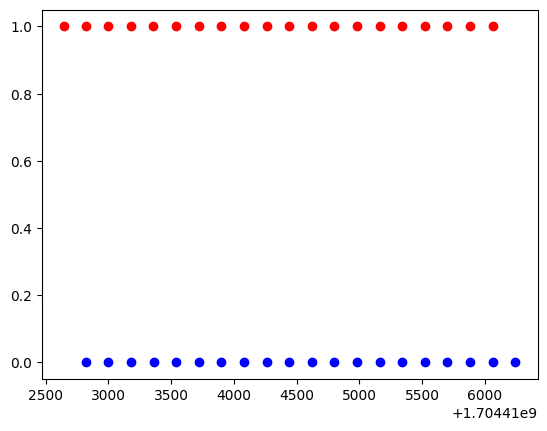

176


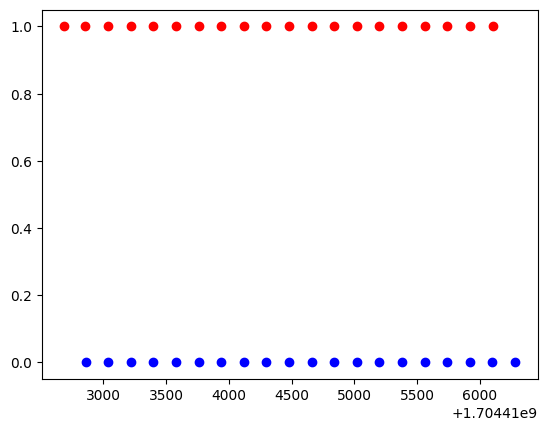

177


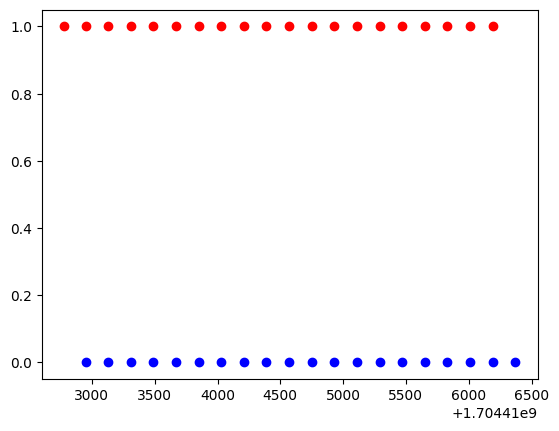

178


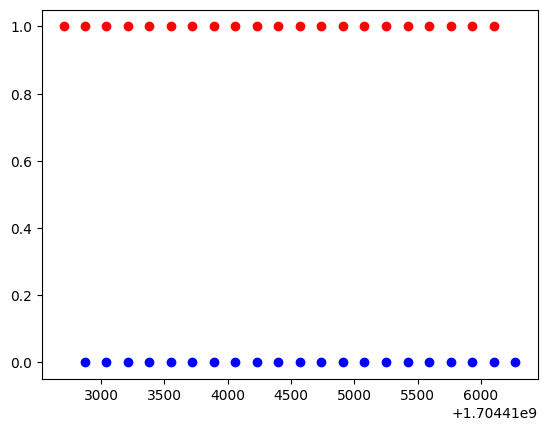

201


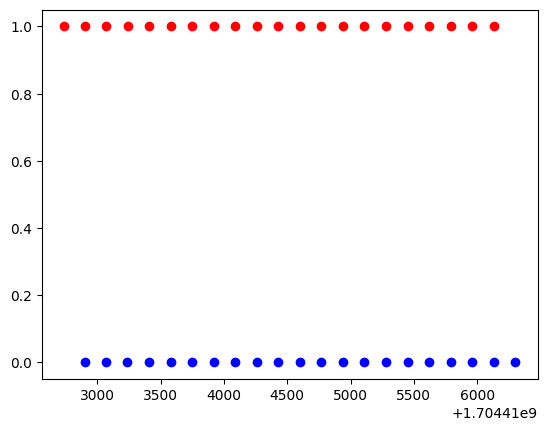

202


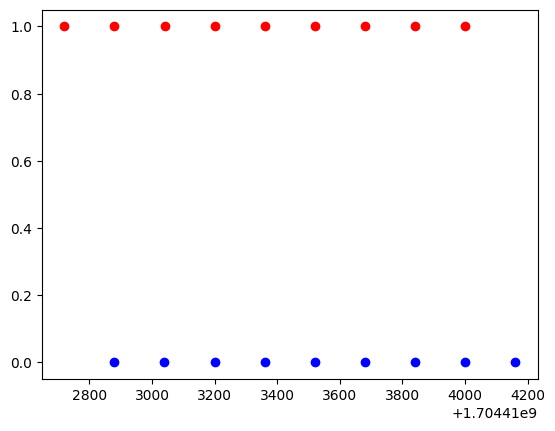

206


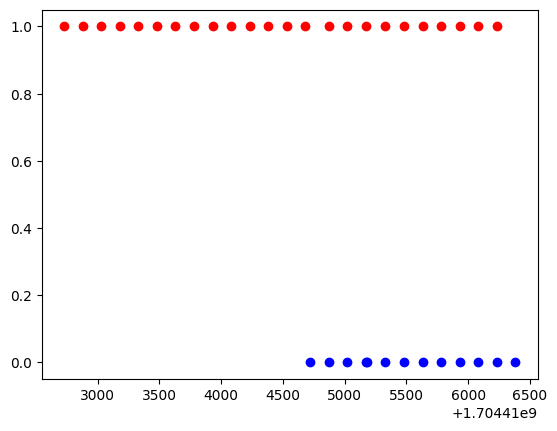

210


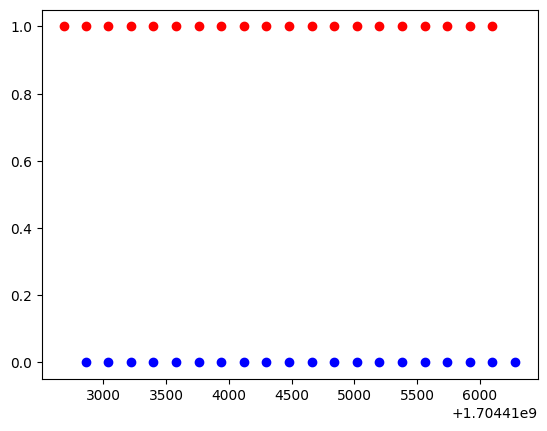

In [175]:
for inter_no in sorted(plan.inter_no.unique()):
    print(inter_no)
    movement = time2movement[present_time]
    movementt = movement.copy()[movement.inter_no==inter_no]
    hrhistoryy = rhistory.copy()[rhistory.inter_no==inter_no]
    mdts = sorted(movementt.start_unix.unique())
    hdts = sorted(hrhistoryy.start_unix.unique())
    import matplotlib.pyplot as plt
    plt.scatter(mdts, [0]*len(mdts), c='b')
    plt.scatter(hdts, [1]*len(hdts), c='r')
    plt.show()
    # display(movementt)
    # display(hrhistoryy)

In [ ]:
# 5초단위로 수집한 이동류정보(time2movement[present_time])와 최근 1시간 신호이력(hrhistory)을 병합
movedur = pd.merge(time2movement[present_time], hrhistory, how='inner', on=['inter_no', 'start_unix', 'phas_A', 'phas_B']) # movements and durations
movedur = movedur.sort_values(by=['start_unix', 'inter_no', 'phas_A','phas_B'])
movedur = movedur[['inter_no', 'start_unix', 'phas_A', 'phas_B', 'move_A', 'move_B', 'duration']]

# 이동류 매칭 테이블에서 진입id, 진출id를 가져와서 붙임.
for i, row in movedur.iterrows():
    inter_no = row.inter_no
    start_unix = row.start_unix
    # incoming and outgoing edges A
    move_A = row.move_A
    if move_A in [17, 18]:
        inc_edge_A = np.nan
        out_edge_A = np.nan
    else:
        match_A = matching[(matching.inter_no == inter_no) & (matching.move_no == move_A)].iloc[0]
        inc_edge_A = match_A.inc_edge
        out_edge_A = match_A.out_edge
    movedur.loc[i, ['inc_edge_A', 'out_edge_A']] = [inc_edge_A, out_edge_A]
    # incoming and outgoing edges B
    move_B = row.move_B
    if move_B in [17, 18]:
        inc_edge_B = np.nan
        out_edge_B = np.nan
    else:
        match_B = matching[(matching.inter_no == inter_no) & (matching.move_no == move_B)].iloc[0]
        inc_edge_B = match_B.inc_edge
        out_edge_B = match_B.out_edge
    movedur.loc[i, ['inc_edge_B', 'out_edge_B']] = [inc_edge_B, out_edge_B]

# 이동류 컬럼 제거
movedur = movedur.drop(['move_A', 'move_B'], axis=1)

histid = movedur.copy() # history with edge ids (incoming and outgoing edge ids)
histid['node_id'] = histid['inter_no'].map(inter2node)
histid = histid[['inter_no', 'node_id', 'start_unix', 'phas_A', 'phas_B', 'duration', 'inc_edge_A', 'out_edge_A', 'inc_edge_B', 'out_edge_B']]
histid = histid[histid.start_unix > present_time - 3600]
# 시뮬레이션 시작시각 : 현재시각 - 600
# 시뮬레이션 종료시각 : 현재시각 - 300
# 현재시각 : present_time, PT
# PT-900 ... PT-600 ... PT-300 ... PT

histidd = histid.copy()[histid.inter_no==175]
histidd['diff'] = histidd['start_unix'].diff()
histidd[:60]

In [140]:
inter_no = 175
rhist = make_histid(100)
rhis = rhist.copy()[rhist.inter_no==inter_no]
rhis['diff'] = rhis['start_unix'].diff()
rhis[:60]

2024-01-05 08:20:00


inter_no node_id  start_unix  phas_A  phas_B  duration     inc_edge_A  \
4         175      i0  1704406870       1       1        40  -571542797_02   
5         175      i0  1704406870       2       2        42  -571500487_01   
6         175      i0  1704406870       3       3        29   571545870_02   
7         175      i0  1704406870       3       4        26   571545870_02   
8         175      i0  1704406870       4       4        33   571510153_02   
22        175      i0  1704407040       1       1        40  -571542797_02   
23        175      i0  1704407040       2       2        42  -571500487_01   
24        175      i0  1704407040       3       3        29   571545870_02   
25        175      i0  1704407040       3       4        26   571545870_02   
26        175      i0  1704407040       4       4        33   571510153_02   
50        175      i0  1704407210       1       1        40  -571542797_02   
51        175      i0  1704407210       2       2        42  -571500487_01   
52        175      i0  1704407210       3       3        29   571545870_02   
53        175      i0  1704407210       3       4        26   571545870_02   
54        175      i0  1704407210       4       4        33   571510153_02   
78        175      i0  1704407380       1       1        40  -571542797_02   
79        175      i0  1704407380       2       2        42  -571500487_01   
80        175      i0  1704407380       3       3        29   571545870_02   
81        175      i0  1704407380       3       4        26   571545870_02   
82        175      i0  1704407380       4       4        33   571510153_02   
148       175      i0  1704407890       1       1        40  -571542797_02   
149       175      i0  1704407890       2       2        42  -571500487_01   
150       175      i0  1704407890       3       3        29   571545870_02   
151       175      i0  1704407890       3       4        26   571545870_02   
152       175      i0  1704407890       4       4        33   571510153_02   
176       175      i0  1704408060       1       1        40  -571542797_02   
177       175      i0  1704408060       2       2        42  -571500487_01   
178       175      i0  1704408060       3       3        29   571545870_02   
179       175      i0  1704408060       3       4        26   571545870_02   
180       175      i0  1704408060       4       4        33   571510153_02   
204       175      i0  1704408230       1       1        40  -571542797_02   
205       175      i0  1704408230       2       2        42  -571500487_01   
206       175      i0  1704408230       3       3        29   571545870_02   
207       175      i0  1704408230       3       4        26   571545870_02   
208       175      i0  1704408230       4       4        33   571510153_02   
238       175      i0  1704408400       1       1        40  -571542797_02   
239       175      i0  1704408400       2       2        42  -571500487_01   
240       175      i0  1704408400       3       3        29   571545870_02   
241       175      i0  1704408400       3       4        26   571545870_02   
242       175      i0  1704408400       4       4        33   571510153_02   
266       175      i0  1704408570       1       1        40  -571542797_02   
267       175      i0  1704408570       2       2        42  -571500487_01   
268       175      i0  1704408570       3       3        29   571545870_02   
269       175      i0  1704408570       3       4        26   571545870_02   
270       175      i0  1704408570       4       4        33   571510153_02   
284       175      i0  1704408740       1       1        40  -571542797_02   
285       175      i0  1704408740       2       2        42  -571500487_01   
286       175      i0  1704408740       3       3        29   571545870_02   
287       175      i0  1704408740       3       4        26   571545870_02   
288       175      i0  1704408740       4       4        33   571510153_02   
307       175      i0  1704

In [118]:
inter_no = 175
histid = make_histid(100)
his = histid.copy()[histid.inter_no==inter_no]
his['diff'] = his['start_unix'].diff()
his[:60]

2024-01-05 08:20:00


inter_no node_id  start_unix  phas_A  phas_B  duration     inc_edge_A  \
4         175      i0  1704406870       1       1        40  -571542797_02   
5         175      i0  1704406870       2       2        42  -571500487_01   
6         175      i0  1704406870       3       3        29   571545870_02   
7         175      i0  1704406870       3       4        26   571545870_02   
8         175      i0  1704406870       4       4        33   571510153_02   
22        175      i0  1704407040       1       1        40  -571542797_02   
23        175      i0  1704407040       2       2        42  -571500487_01   
24        175      i0  1704407040       3       3        29   571545870_02   
25        175      i0  1704407040       3       4        26   571545870_02   
26        175      i0  1704407040       4       4        33   571510153_02   
50        175      i0  1704407210       1       1        40  -571542797_02   
51        175      i0  1704407210       2       2        42  -571500487_01   
52        175      i0  1704407210       3       3        29   571545870_02   
53        175      i0  1704407210       3       4        26   571545870_02   
54        175      i0  1704407210       4       4        33   571510153_02   
78        175      i0  1704407380       1       1        40  -571542797_02   
79        175      i0  1704407380       2       2        42  -571500487_01   
80        175      i0  1704407380       3       3        29   571545870_02   
81        175      i0  1704407380       3       4        26   571545870_02   
82        175      i0  1704407380       4       4        33   571510153_02   
148       175      i0  1704407890       1       1        40  -571542797_02   
149       175      i0  1704407890       2       2        42  -571500487_01   
150       175      i0  1704407890       3       3        29   571545870_02   
151       175      i0  1704407890       3       4        26   571545870_02   
152       175      i0  1704407890       4       4        33   571510153_02   
176       175      i0  1704408060       1       1        40  -571542797_02   
177       175      i0  1704408060       2       2        42  -571500487_01   
178       175      i0  1704408060       3       3        29   571545870_02   
179       175      i0  1704408060       3       4        26   571545870_02   
180       175      i0  1704408060       4       4        33   571510153_02   
204       175      i0  1704408230       1       1        40  -571542797_02   
205       175      i0  1704408230       2       2        42  -571500487_01   
206       175      i0  1704408230       3       3        29   571545870_02   
207       175      i0  1704408230       3       4        26   571545870_02   
208       175      i0  1704408230       4       4        33   571510153_02   
238       175      i0  1704408400       1       1        40  -571542797_02   
239       175      i0  1704408400       2       2        42  -571500487_01   
240       175      i0  1704408400       3       3        29   571545870_02   
241       175      i0  1704408400       3       4        26   571545870_02   
242       175      i0  1704408400       4       4        33   571510153_02   
266       175      i0  1704408570       1       1        40  -571542797_02   
267       175      i0  1704408570       2       2        42  -571500487_01   
268       175      i0  1704408570       3       3        29   571545870_02   
269       175      i0  1704408570       3       4        26   571545870_02   
270       175      i0  1704408570       4       4        33   571510153_02   
284       175      i0  1704408740       1       1        40  -571542797_02   
285       175      i0  1704408740       2       2        42  -571500487_01   
286       175      i0  1704408740       3       3        29   571545870_02   
287       175      i0  1704408740       3       4        26   571545870_02   
288       175      i0  1704408740       4       4        33   571510153_02   
307       175      i0  1704

In [16]:
for m in range(30, 288):
    print(m)
    make_histid(m).to_csv(f'../../Data/tables/histids/histids_{fmins[m]}.csv')

30
2024-01-05 02:30:00
31
2024-01-05 02:35:00
32
2024-01-05 02:40:00
33
2024-01-05 02:45:00
34
2024-01-05 02:50:00
35
2024-01-05 02:55:00
36
2024-01-05 03:00:00
37
2024-01-05 03:05:00
38
2024-01-05 03:10:00
39
2024-01-05 03:15:00
40
2024-01-05 03:20:00
41
2024-01-05 03:25:00
42
2024-01-05 03:30:00
43
2024-01-05 03:35:00
44
2024-01-05 03:40:00
45
2024-01-05 03:45:00
46
2024-01-05 03:50:00
47
2024-01-05 03:55:00
48
2024-01-05 04:00:00
49
2024-01-05 04:05:00
50
2024-01-05 04:10:00
51
2024-01-05 04:15:00
52
2024-01-05 04:20:00
53
2024-01-05 04:25:00
54
2024-01-05 04:30:00
55
2024-01-05 04:35:00
56
2024-01-05 04:40:00
57
2024-01-05 04:45:00
58
2024-01-05 04:50:00
59
2024-01-05 04:55:00
60
2024-01-05 05:00:00
61
2024-01-05 05:05:00
62
2024-01-05 05:10:00
63
2024-01-05 05:15:00
64
2024-01-05 05:20:00
65
2024-01-05 05:25:00
66
2024-01-05 05:30:00
67
2024-01-05 05:35:00
68
2024-01-05 05:40:00
69
2024-01-05 05:45:00
70
2024-01-05 05:50:00
71
2024-01-05 05:55:00
72
2024-01-05 06:00:00
73
2024-01-